# Notebook 04 — Topic Modeling & Narrative Discovery

**Goal:** identify dominant market narratives present in financial news headlines
using topic modeling.

**Why topic modeling:** unlike clustering, topic models explicitly describe each
theme as a distribution over words, making results easier to interpret and communicate.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Load cleaned dataset

We load the cleaned headline dataset produced in Notebook 02.
Using the same normalized text ensures consistency across all NLP analyses.

In [2]:
df = pd.read_parquet("../data/processed/news_clean.parquet")
df.shape

(53155, 9)

## Select text input for topic modeling

We use the cleaned headline text (`headline_clean`) as input.
Headlines are short but information-dense, making them suitable for discovering
high-level narrative themes.

In [3]:
texts = df["headline_clean"].astype(str).values

## Vectorize text using bag-of-words

LDA requires a count-based representation.
We use CountVectorizer to:
- convert headlines into word-count vectors
- remove very common and very rare terms
- limit vocabulary size for stability and interpretability

In [4]:
vectorizer = CountVectorizer(
    max_features=15000,
    stop_words="english",
    min_df=5,
    max_df=0.8
)

X = vectorizer.fit_transform(texts)
X.shape

(53155, 8158)

## Choose number of topics

The number of topics is a modeling choice.
We aim for a small number of broad, interpretable narratives rather than many narrow ones.
We start with 10 topics as a reasonable balance.

## Fit LDA topic model

We fit an LDA model to learn latent topics, where each topic represents
a probability distribution over words.

In [5]:
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

lda.fit(X)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## Inspect discovered topics

We extract the highest-weight words for each topic.
These words summarize the narrative captured by each topic.

In [6]:
terms = np.array(vectorizer.get_feature_names_out())

def top_words_for_topic(topic_idx, top_n=12):
    topic = lda.components_[topic_idx]
    return terms[np.argsort(topic)[::-1][:top_n]]

topic_words = {
    i: top_words_for_topic(i, top_n=12)
    for i in range(n_topics)
}

topic_words

{0: array(['business', 'live', 'coronavirus', 'china', 'year', 'growth',
        'happened', 'sales', 'quarter', 'uk', 'economy', 'hit'],
       dtype=object),
 1: array(['finance', 'nils', 'pratley', 'close', 'jobs', 'pay', 'stores',
        'uk', 'ceo', 'cook', 'new', 'thomas'], dtype=object),
 2: array(['uk', 'firms', 'coronavirus', 'business', 'crisis', '19', 'covid',
        'big', 'brexit', 'economy', 'says', 'banks'], dtype=object),
 3: array(['new', 'huawei', 'says', 'amazon', 'eu', 'court', 'case', 'china',
        'credit', 'bank', 'ban', 'probe'], dtype=object),
 4: array(['cramer', 'stock', 'ceo', 'market', 'says', 'round', 'jim',
        'lightning', 'buy', 'stocks', 'remix', 'earnings'], dtype=object),
 5: array(['oil', 'bank', 'saudi', 'says', 'deutsche', 'opec', 'england',
        'energy', 'iran', 'prices', 'sanctions', 'cut'], dtype=object),
 6: array(['street', 'wall', 'stocks', 'fed', 'shares', 'uk', 'dollar',
        'rise', 'high', 'brexit', 'rate', 'global'], dty

In [7]:
for i in range(n_topics):
    print(f"\nTopic {i}:")
    print(", ".join(topic_words[i]))


Topic 0:
business, live, coronavirus, china, year, growth, happened, sales, quarter, uk, economy, hit

Topic 1:
finance, nils, pratley, close, jobs, pay, stores, uk, ceo, cook, new, thomas

Topic 2:
uk, firms, coronavirus, business, crisis, 19, covid, big, brexit, economy, says, banks

Topic 3:
new, huawei, says, amazon, eu, court, case, china, credit, bank, ban, probe

Topic 4:
cramer, stock, ceo, market, says, round, jim, lightning, buy, stocks, remix, earnings

Topic 5:
oil, bank, saudi, says, deutsche, opec, england, energy, iran, prices, sanctions, cut

Topic 6:
street, wall, stocks, fed, shares, uk, dollar, rise, high, brexit, rate, global

Topic 7:
billion, boeing, sources, exclusive, max, 737, million, uber, airlines, facebook, ipo, deal

Topic 8:
uk, car, tesla, industry, jobs, 000, plant, brexit, says, electric, production, cars

Topic 9:
china, trade, trump, says, deal, talks, tariffs, nissan, eu, war, house, renault


## Assign dominant topic to each headline

For interpretability, each headline is assigned to the topic
with the highest probability.

In [8]:
topic_probs = lda.transform(X)
df["topic"] = topic_probs.argmax(axis=1)

df[["source", "headline_clean", "topic"]].head()

,source,headline_clean,topic
0,CNBC,jim cramer: a better way to invest in the covi...,2
1,CNBC,cramer's lightning round: i would own teradyne,4
2,CNBC,"cramer's week ahead: big week for earnings, ev...",4
3,CNBC,iq capital ceo keith bliss says tech and healt...,6
4,CNBC,wall street delivered the 'kind of pullback i'...,4


## Inspect example headlines per topic

We sample real headlines from each topic to validate that
topic keywords align with actual content.
This prevents blindly trusting the model output.

In [9]:
for t in range(n_topics):
    print(f"\n=== Topic {t} ===")
    samples = df[df["topic"] == t].sample(
        n=min(5, (df["topic"] == t).sum()),
        random_state=42
    )
    for _, row in samples.iterrows():
        print(f"- [{row['source']}] {row['headline_clean']}")


=== Topic 0 ===
- [Reuters] lloyd's of london meets second-quarter electronic trading target
- [Guardian] business live trump rattles markets as us economy adds 164,000 jobs in july as it happened
- [Reuters] siemens looks for faster growth in 'smart' buildings, eyes acquisitions
- [Guardian] business live uk house price slowdown china growth beats forecasts - as it happened
- [Guardian] bullring owner targets 900m-plus sell-off as retail crisis bites

=== Topic 1 ===
- [Guardian] santander to close 140 branches, putting more than 1,200 jobs at risk
- [Reuters] exclusive: aston martin triggers contingency plans for no deal brexit
- [Reuters] fiat chrysler ceo says group to produce face masks in asia: union representative
- [Reuters] global miner bhp taps australia head henry as new ceo
- [Guardian] morrisons faces employment tribunal claim over equal pay

=== Topic 2 ===
- [Guardian] uk has more than 750,000 property millionaires
- [Reuters] facebook, google ask san francisco staff to

## Compare topics across news sources

We analyze how frequently each topic appears within each news source.
This reveals differences in narrative emphasis and editorial focus.

In [10]:
topic_dist = pd.crosstab(df["source"], df["topic"], normalize="index")
topic_dist

topic,0,1,2,3,4,5,6,7,8,9
source,,,,,,,,,,
CNBC,0.032640,0.010043,0.034792,0.011119,0.763630,0.011478,0.058106,0.021879,0.022956,0.033357
Guardian,0.110761,0.143186,0.231020,0.073504,0.057151,0.075190,0.083450,0.034504,0.132116,0.059118
Reuters,0.113809,0.065148,0.054003,0.130695,0.034232,0.088665,0.108038,0.161642,0.096862,0.146905


<Figure size 1200x500 with 0 Axes>

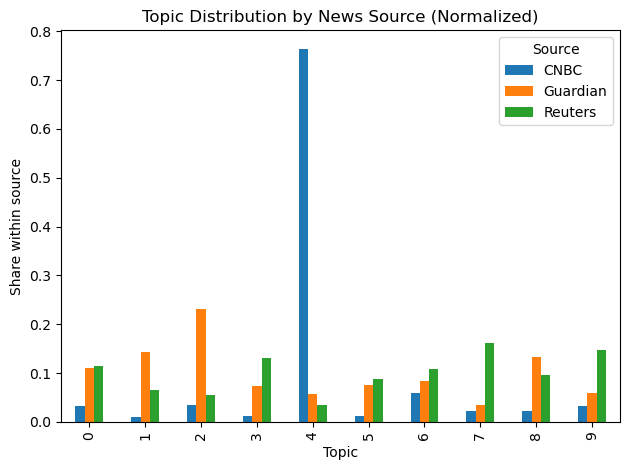

In [11]:
plt.figure(figsize=(12, 5))
topic_dist.T.plot(kind="bar")
plt.title("Topic Distribution by News Source (Normalized)")
plt.xlabel("Topic")
plt.ylabel("Share within source")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

## Save topic modeling outputs

We save topic assignments and keyword summaries for use
in the final project summary and reporting.

In [12]:
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

df.to_parquet(out_dir / "news_with_topics.parquet", index=False)

topic_df = pd.DataFrame({
    "topic": list(topic_words.keys()),
    "top_words": [", ".join(topic_words[t]) for t in topic_words]
})

topic_df.to_csv(out_dir / "lda_topics.csv", index=False)

(out_dir / "news_with_topics.parquet").as_posix(), (out_dir / "lda_topics.csv").as_posix()

('../data/processed/news_with_topics.parquet',
 '../data/processed/lda_topics.csv')

## Summary

In this notebook we:
- applied topic modeling (LDA) to cleaned financial news headlines
- identified recurring market narratives
- validated topics using real headline examples
- compared narrative emphasis across news sources
- saved topic modeling outputs for final analysis